In [1]:
import pandas as pd
from pandasql import sqldf
import numpy as np
# import matplotlib.pyplot as plt
# %matplotlib inline

In [2]:
cd /Users/jeff/Documents/Notebooks

/Users/jeff/Documents/Notebooks


In [3]:
filepath = "./Data/"

id_cost = pd.read_csv(filepath + "interviewdata-cost.csv")
id_rev  = pd.read_csv(filepath + "interviewdata-rev.csv")

#id_cost.head(3)
#id_rev.head(3)

In [4]:
table_1 = pd.merge(id_cost,id_rev,on=['date','source_id'],how='outer', indicator=True)
print(table_1)

           date source_id    cost  revenue      _merge
0      10/17/14    PA0577  7168.0   8417.0        both
1       8/17/14    PA0354  7615.0   4200.0        both
2        1/7/14    PA0607  4054.0   7935.0        both
3       8/25/14    PA0745  9317.0   5536.0        both
4      11/30/14    PA0923  5586.0      NaN   left_only
...         ...       ...     ...      ...         ...
14613  12/29/14    PA0958     NaN   7406.0  right_only
14614   3/19/14    PA0732     NaN   6584.0  right_only
14615   9/24/14    PA0174     NaN   3827.0  right_only
14616  10/26/14    PA0318     NaN    533.0  right_only
14617    1/4/14    PA0354     NaN   3070.0  right_only

[14618 rows x 5 columns]


In [5]:
print(sqldf("""
    SELECT *
    FROM table_1
    WHERE _merge = "left_only"
    LIMIT 10000
""", locals()))

          date source_id    cost revenue     _merge
0     11/30/14    PA0923  5586.0    None  left_only
1     12/17/14    PA0952  6662.0    None  left_only
2      5/22/14    PA0411  4795.0    None  left_only
3     10/14/14    PA0168  9651.0    None  left_only
4      2/13/14    PA0354  2752.0    None  left_only
...        ...       ...     ...     ...        ...
4613   12/7/14    PA0900  2037.0    None  left_only
4614   7/11/14    PA0474   726.0    None  left_only
4615   1/10/14    PA0830  6202.0    None  left_only
4616   1/31/14    PA0467  7057.0    None  left_only
4617   10/1/14    PA0293  1053.0    None  left_only

[4618 rows x 5 columns]


In [6]:
print(sqldf("""
    SELECT 
        source_id,
        sum(revenue) as "annual_revenue",
        rank() over (order by sum(revenue) desc) as annual_rank
    FROM table_1
    GROUP BY source_id
    ORDER BY sum(revenue) desc
    LIMIT 4
""", locals()))

  source_id  annual_revenue  annual_rank
0    PA0527       1385747.0            1
1    PA0308       1338615.0            2
2    PA0352       1309685.0            3
3    PA0552       1283190.0            4


In [7]:
table_1.date = pd.to_datetime(table_1.date)

q = """
    SELECT 
        strftime("%m/%Y", table_1.date) as "Month_Year",
        strftime("%m", table_1.date) as "Month",
        strftime("%Y", table_1.date) as "Year",
        
        max(case when t2.annual_rank = 1 then table_1.source_id else NULL end)
            as source_1,
        sum(case when t2.annual_rank = 1 then table_1.revenue else null end)
            as revenue_1,
        max(case when t2.annual_rank = 2 then table_1.source_id else NULL end)
            as source_2,
        sum(case when t2.annual_rank = 2 then table_1.revenue else null end)
            as revenue_2,
        max(case when t2.annual_rank = 3 then table_1.source_id else null end)
            as source_3,
        sum(case when t2.annual_rank = 3 then table_1.revenue else null end)
            as revenue_3, 
        max(case when t2.annual_rank = 4 then table_1.source_id else null end)
            as source_4,
        sum(case when t2.annual_rank = 4 then table_1.revenue else null end)
            as revenue_4

    FROM table_1 
        INNER JOIN (
            SELECT 
                source_id,
                sum(revenue) as "Total Revenue",
                rank() over (order by sum(revenue) desc) as annual_rank
            FROM table_1
            GROUP BY source_id
            ORDER BY sum(revenue) desc
            LIMIT 4
            ) t2
            ON table_1.source_id = t2.source_id
    GROUP BY 1,2,3
    ORDER BY Month_Year
"""
table_2 = sqldf(q,locals())
print(table_2)

   Month_Year Month  Year source_1  revenue_1 source_2  revenue_2 source_3  \
0     01/2014    01  2014   PA0527   111528.0   PA0308    74573.0   PA0352   
1     02/2014    02  2014   PA0527   105195.0   PA0308   108134.0   PA0352   
2     03/2014    03  2014   PA0527   135439.0   PA0308   142817.0   PA0352   
3     04/2014    04  2014   PA0527   112385.0   PA0308   164805.0   PA0352   
4     05/2014    05  2014   PA0527   114339.0   PA0308   122349.0   PA0352   
5     06/2014    06  2014   PA0527   112022.0   PA0308    76398.0   PA0352   
6     07/2014    07  2014   PA0527   128733.0   PA0308   104544.0   PA0352   
7     08/2014    08  2014   PA0527    91288.0   PA0308    99909.0   PA0352   
8     09/2014    09  2014   PA0527   140484.0   PA0308    99915.0   PA0352   
9     10/2014    10  2014   PA0527   135752.0   PA0308   113668.0   PA0352   
10    11/2014    11  2014   PA0527    66297.0   PA0308   107097.0   PA0352   
11    12/2014    12  2014   PA0527   132285.0   PA0308   124406.

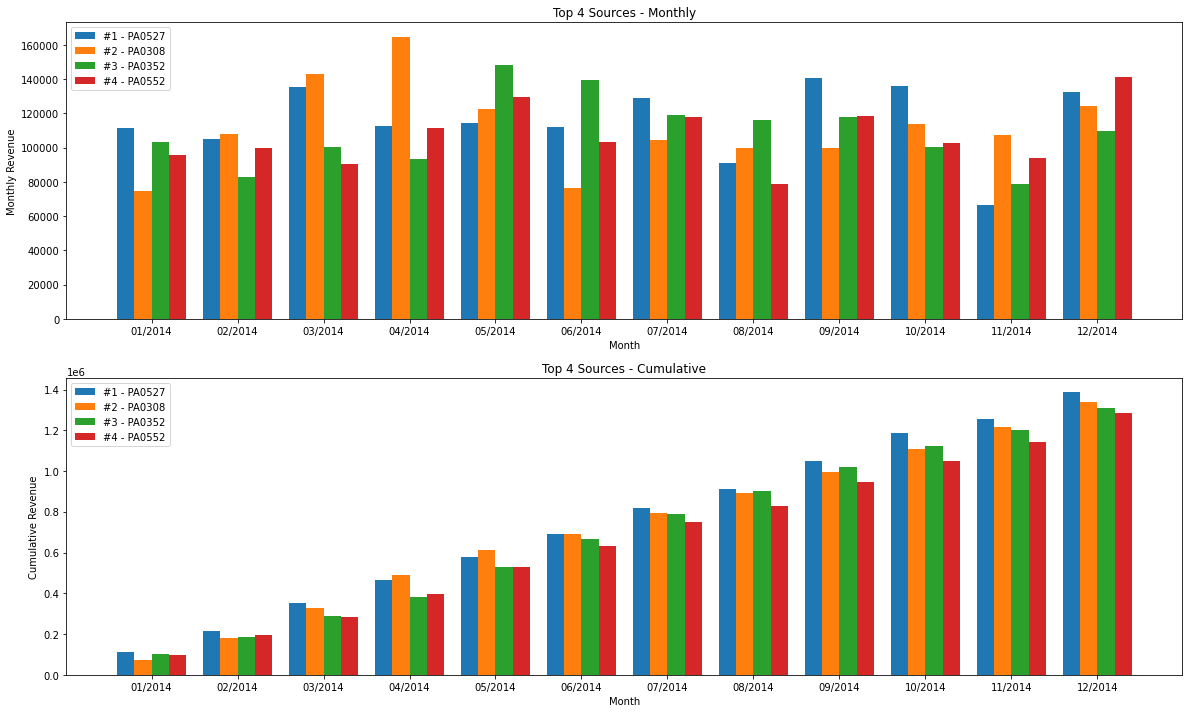

In [8]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.ticker import MaxNLocator

fig_1 = plt.figure(1, figsize=(20,12))
monthly_revenue = fig_1.add_subplot(211)
cumulative_monthly_revenue = fig_1.add_subplot(212)

x = np.arange(len(table_2.Month_Year))  # the label locations
width = 0.2  # the width of the bars

table_2.Month_Year = pd.to_datetime(table_2.Month_Year)
table_2.Month_Year = table_2.Month_Year.dt.strftime('%m/%Y')

rects1 = monthly_revenue.bar(x - width*3/2, table_2.revenue_1, width)
rects2 = monthly_revenue.bar(x - width/2  , table_2.revenue_2, width)
rects3 = monthly_revenue.bar(x + width/2  , table_2.revenue_3, width)
rects4 = monthly_revenue.bar(x + width*3/2, table_2.revenue_4, width)

line1 = cumulative_monthly_revenue.bar(x - width*3/2, table_2.revenue_1.cumsum(), width)
line2 = cumulative_monthly_revenue.bar(x - width/2  , table_2.revenue_2.cumsum(), width)
line3 = cumulative_monthly_revenue.bar(x + width/2  , table_2.revenue_3.cumsum(), width)
line4 = cumulative_monthly_revenue.bar(x + width*3/2, table_2.revenue_4.cumsum(), width)

monthly_revenue.set_ylabel('Monthly Revenue')
monthly_revenue.set_xlabel('Month')
monthly_revenue.set_title('Top 4 Sources - Monthly')
monthly_revenue.set_xticks(x, table_2.Month_Year)

cumulative_monthly_revenue.set_ylabel('Cumulative Revenue')
cumulative_monthly_revenue.set_xlabel('Month')
cumulative_monthly_revenue.set_title('Top 4 Sources - Cumulative')
cumulative_monthly_revenue.set_xticks(x, table_2.Month_Year)

mylabels = ['#1 - ' + np.max(table_2.source_1), 
            '#2 - ' + np.max(table_2.source_2), 
            '#3 - ' + np.max(table_2.source_3), 
            '#4 - ' + np.max(table_2.source_4)]

monthly_revenue.legend(labels = mylabels)
cumulative_monthly_revenue.legend(labels = mylabels)

plt.show()

In [77]:
from sklearn.model_selection import train_test_split
from math import exp
activity_data = pd.read_csv(filepath + "interviewdata-activity.csv")
activity_data
# activity_data.iloc[:,(6)]
# activity_data.iloc[:,(1)]
# x = pd.read_csv(filepath + "interviewdata-activity.csv", usecols=[2,3,4,5])
# print(x)

,userid,date,age,gender,metropolitan_area,device_type,active
0,4e3a9ea937b3a,8/4/15,30,F,Detroit,Tablet,1
1,4e3dd5154a08c,8/6/15,43,F,Charlotte,Desktop,1
2,4e3df1ecd131a,8/6/15,41,F,Tampa,Mobile,1
3,4e4e77461b1e3,8/19/15,56,F,Nashville,Desktop,1
4,4e4eb59b6de55,8/19/15,33,F,Detroit,Mobile,1
...,...,...,...,...,...,...,...
5415,4e9cce2b66d44,10/17/15,21,M,Houston,Tablet,0
5416,4f2ab00039f50,2/2/16,42,F,Birmingham,Mobile,0
5417,4e642e7208f6b,9/4/15,40,F,Houston,Mobile,0
5418,4f40149878765,2/18/16,40,F,Houston,Mobile,0


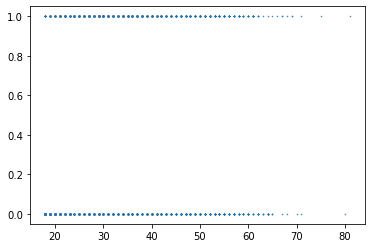

In [48]:
# Referencing this doc: https://towardsdatascience.com/logistic-regression-explained-and-implemented-in-python-880955306060
import numpy as np
from sklearn.model_selection import train_test_split
from math import exp


# Visualizing the dataset
plt.scatter(activity_data.age, activity_data.active, s=0.25)
plt.show

# Divide the data to training set and test set
X_train, X_test, y_train, y_test = train_test_split(activity_data.age, activity_data.active, test_size=0.20)


In [54]:
# Creating the logistic regression model

# Helper function to normalize data
def normalize(X):
    return X - X.mean()

# Method to make predictions
def predict(X, b0, b1):
    return np.array([1 / (1 + exp(-1*b0 + -1*b1*x)) for x in X])

# Method to train the model
def logistic_regression(X, Y):

    X = normalize(X)

    # Initializing variables
    b0 = 0
    b1 = 0
    L = 0.001
    epochs = 300

    for epoch in range(epochs):
        y_pred = predict(X, b0, b1)
        D_b0 = -2 * sum((Y - y_pred) * y_pred * (1 - y_pred))  # Derivative of loss wrt b0
        D_b1 = -2 * sum(X * (Y - y_pred) * y_pred * (1 - y_pred))  # Derivative of loss wrt b1
        # Update b0 and b1
        b0 = b0 - L * D_b0
        b1 = b1 - L * D_b1
    
    return b0, b1

In [ ]:
# Training the model
b0, b1 = logistic_regression(X_train, y_train)

# Making predictions
X_test_norm = normalize(X_test)
y_pred = predict(X_test_norm, b0, b1)
y_pred = [1 if p >= 0.5 else 0 for p in y_pred]

plt.clf()
plt.scatter(X_test, y_test)
plt.scatter(X_test, y_pred, c="red")
plt.show()

# The accuracy
accuracy = 0
for i in range(len(y_pred)):
    if y_pred[i] == y_test.iloc[i]:
        accuracy += 1
print(f"Accuracy = {accuracy / len(y_pred)}")
# Accuracy = 0.5535055350553506

# This doc I'm referencing only uses a single feature to model the 'activity'. 
# I found some other websites to reference, but it's taking me some time to 
# figure out some of the data extraction/transformations in python.

In [80]:
# 2nd attempt on 4, but not sure how to incorporate multiple x coefficients into this example

# x = pd.read_csv(filepath + "interviewdata-activity.csv", usecols=[2,3,4,5])
# y = activity_data.iloc[:,6]

# # Visualizing the dataset
# plt.scatter(x,y)
# plt.show()
# activity_data.gender[activity_data.gender == 'M'] = 1
# activity_data.gender[activity_data.gender == 'F'] = 0

-----------------------------------------------------------------------------------------
# Reference: https://towardsdatascience.com/linear-regression-using-python-b136c91bf0a2
# imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# generate random data-set
x = pd.read_csv(filepath + "interviewdata-activity.csv", usecols=[2,3,4,5])
y = activity_data.iloc[:,6]

# sckit-learn implementation

# Model initialization
regression_model = LinearRegression()
# Fit the data(train the model)
regression_model.fit(x, y)
# Predict
y_predicted = regression_model.predict(x)

# model evaluation
rmse = mean_squared_error(y, y_predicted)
r2 = r2_score(y, y_predicted)

# printing values
print('Slope:' ,regression_model.coef_)
print('Intercept:', regression_model.intercept_)
print('Root mean squared error: ', rmse)
print('R2 score: ', r2)

# plotting values

# data points
plt.scatter(x, y, s=10)
plt.xlabel('x')
plt.ylabel('y')

# predicted values
plt.plot(x, y_predicted, color='r')
plt.show()



SyntaxError: invalid syntax (3267087836.py, line 12)

In [131]:
# from pyspark.sql import SparkSession
import json
id_parse = pd.read_csv(filepath + "interviewdata-parsing.csv")


data_to_parse = id_parse.iloc[:,1]
data_to_parse.head

split = id_parse.pop('data_to_parse').str.extract(r'("value")\:\"(\S+)\;(\S+)\;(\S+)\;(\S+)\"\}\]')
split.head()

,0,1,2,3,4
0,"""value""",N,U,A7,W
1,"""value""",N,U,I6,W
2,"""value""",Y,U,A7,W
3,"""value""",N,U,I1,W
4,"""value""",Y,U,A7,W
